In [1]:
import pandas as pd
import numpy as np
import os
import sys
from wordcloud import WordCloud, STOPWORDS
import collections
import nltk
from nltk.stem import WordNetLemmatizer
  
import re
from nlp_profiler.core import apply_text_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [WinError 10054] An existing connection was forcibly
[nltk_data]     closed by the remote host>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>
[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


#### Importing data

In [2]:
fileList = os.listdir('../data')

In [3]:
data = pd.DataFrame()
for i in fileList:
    data = pd.concat([data, pd.read_excel('../data/'+i)])

In [4]:
data.reset_index(inplace = True)

#### Basic summary stats

In [5]:
data.shape

(4881, 28)

In [6]:
data.head(2)

,index,OSHPD ID,Manufacturer Name,Date Reported,NDC Number,Drug Product Description,WAC Effective Date,WAC Increase Amount,WAC After Increase,Patent Expiration Date,...,Company Acquired From,Acquisition Price,Acquisition Price Non-Public Indicator,Acquisition Price Comment,WAC at Acquisition,WAC Year Prior to Acquisition,Year Drug Introduced to Market,WAC at Intro to Market,Supporting Documents,General Comments
0,0,Rx0000018,ACADIA Pharmaceuticals Inc.,12/31/2019,63090034030,NUPLAZID Oral Capsule 34 MG 30,12/30/2019,155.0,3341.0,08/27/2038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The information contained in this report is su...
1,1,Rx0000018,ACADIA Pharmaceuticals Inc.,12/31/2019,63090010030,NUPLAZID Oral Tablet 10 MG 30,12/30/2019,155.0,3341.0,03/23/2037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The information contained in this report is su...


In [7]:
data.columns

Index(['index', 'OSHPD ID', 'Manufacturer Name', 'Date Reported', 'NDC Number',
       'Drug Product Description', 'WAC Effective Date', 'WAC Increase Amount',
       'WAC After Increase', 'Patent Expiration Date', 'Drug Source Type',
       'Unit Sales Volume in US', 'Unit Sales Volume Non-Public Indicator',
       'Cost Increase Factors', 'Cost Increase Factors Non-Public Indicator',
       'Change Improvement Description',
       'Change Improvement Non-Public Indicator', 'Acquisition Date',
       'Company Acquired From', 'Acquisition Price',
       'Acquisition Price Non-Public Indicator', 'Acquisition Price Comment',
       'WAC at Acquisition', 'WAC Year Prior to Acquisition',
       'Year Drug Introduced to Market', 'WAC at Intro to Market',
       'Supporting Documents', 'General Comments'],
      dtype='object')

###### Missing values

<AxesSubplot:xlabel='Metric'>

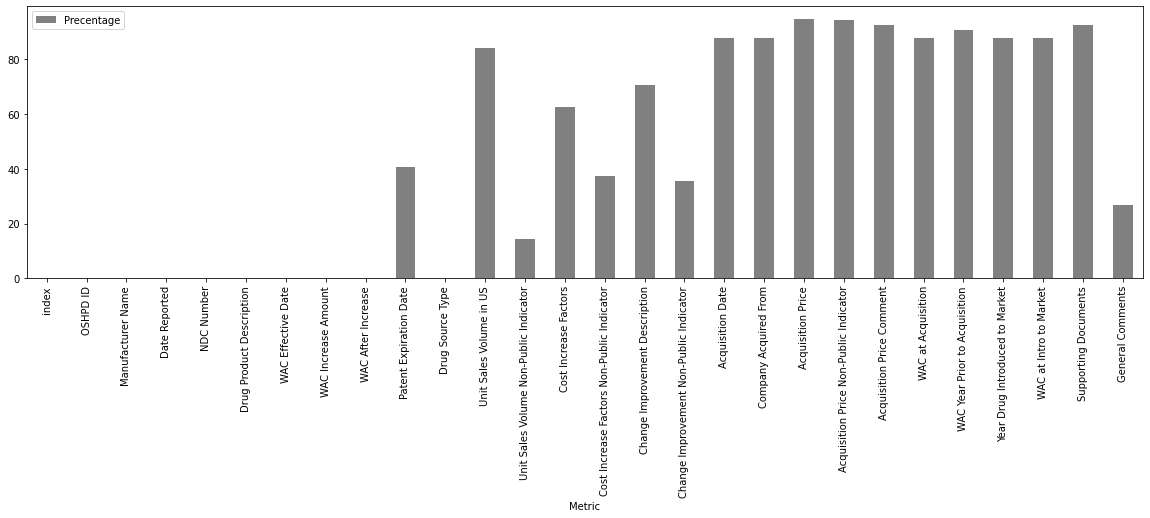

In [8]:
missingDf = pd.DataFrame({'Metric': list(data.isna().sum().index), 'Missing Count': list(data.isna().sum())})
missingDf['Precentage'] = missingDf['Missing Count']*100/data.shape[0]
missingDf.plot(x ='Metric', y='Precentage', kind = 'bar', figsize = (20, 5), color = 'grey')

In [9]:
missingDf

,Metric,Missing Count,Precentage
0,index,0,0.000000
1,OSHPD ID,0,0.000000
2,Manufacturer Name,0,0.000000
3,Date Reported,0,0.000000
4,NDC Number,0,0.000000
5,Drug Product Description,0,0.000000
6,WAC Effective Date,0,0.000000
7,WAC Increase Amount,0,0.000000
8,WAC After Increase,0,0.000000
9,Patent Expiration Date,1989,40.749846


###### Key Stats - Describe

In [10]:
data.describe(include = 'all')

,index,OSHPD ID,Manufacturer Name,Date Reported,NDC Number,Drug Product Description,WAC Effective Date,WAC Increase Amount,WAC After Increase,Patent Expiration Date,...,Company Acquired From,Acquisition Price,Acquisition Price Non-Public Indicator,Acquisition Price Comment,WAC at Acquisition,WAC Year Prior to Acquisition,Year Drug Introduced to Market,WAC at Intro to Market,Supporting Documents,General Comments
count,4881.000000,4881,4881,4881,4.881000e+03,4881,4881,4881.000000,4881.000000,2892,...,599,2.590000e+02,274.0,366,599.000000,455.000000,599.000000,598.00000,357,3567
unique,NaN,224,227,16,NaN,3683,324,NaN,NaN,514,...,110,NaN,NaN,93,NaN,NaN,NaN,NaN,357,557
top,NaN,Rx0000020,Allergan,03/31/2019,NaN,LEU TechneLite® (Technetium Tc99m Generator),01/01/2019,NaN,NaN,10/19/2037,...,IMPAX,NaN,NaN,This deal was a merger in which Impax sharehol...,NaN,NaN,NaN,NaN,https://reports.siera.oshpd.ca.gov/api/report/...,For Column F as reflected in the FDA publicati...
freq,NaN,317,317,1108,NaN,13,562,NaN,NaN,50,...,54,NaN,NaN,55,NaN,NaN,NaN,NaN,1,174
mean,617.050604,NaN,NaN,NaN,3.458457e+10,NaN,NaN,222.915249,3496.203307,NaN,...,NaN,1.093140e+09,1.0,NaN,2743.837112,2063.558242,2011.490818,2216.83408,NaN,NaN
std,364.757413,NaN,NaN,NaN,2.904955e+10,NaN,NaN,779.681737,8327.335201,NaN,...,NaN,3.240078e+09,0.0,NaN,5244.623715,3907.781999,7.980295,4428.27829,NaN,NaN
min,0.000000,NaN,NaN,NaN,2.143380e+06,NaN,NaN,0.030000,13.690000,NaN,...,NaN,0.000000e+00,1.0,NaN,1.000000,0.000000,1961.000000,0.01000,NaN,NaN
25%,305.000000,NaN,NaN,NaN,4.096648e+08,NaN,NaN,22.990000,369.060000,NaN,...,NaN,1.750000e+07,1.0,NaN,307.700000,227.115000,2010.000000,198.78250,NaN,NaN
50%,610.000000,NaN,NaN,NaN,4.420605e+10,NaN,NaN,55.210000,818.970000,NaN,...,NaN,8.700000e+07,1.0,NaN,607.850000,500.000000,2014.000000,402.09000,NaN,NaN
75%,915.000000,NaN,NaN,NaN,6.195807e+10,NaN,NaN,175.860000,2555.890000,NaN,...,NaN,3.110000e+08,1.0,NaN,3286.555000,1271.390000,2015.000000,1875.00000,NaN,NaN


In [11]:
data.columns

Index(['index', 'OSHPD ID', 'Manufacturer Name', 'Date Reported', 'NDC Number',
       'Drug Product Description', 'WAC Effective Date', 'WAC Increase Amount',
       'WAC After Increase', 'Patent Expiration Date', 'Drug Source Type',
       'Unit Sales Volume in US', 'Unit Sales Volume Non-Public Indicator',
       'Cost Increase Factors', 'Cost Increase Factors Non-Public Indicator',
       'Change Improvement Description',
       'Change Improvement Non-Public Indicator', 'Acquisition Date',
       'Company Acquired From', 'Acquisition Price',
       'Acquisition Price Non-Public Indicator', 'Acquisition Price Comment',
       'WAC at Acquisition', 'WAC Year Prior to Acquisition',
       'Year Drug Introduced to Market', 'WAC at Intro to Market',
       'Supporting Documents', 'General Comments'],
      dtype='object')

In [12]:
data.groupby(['Manufacturer Name'], as_index = False).count()[['Manufacturer Name', 'Drug Product Description']].sort_values(['Drug Product Description'], ascending = False).head(100)

,Manufacturer Name,Drug Product Description
19,Allergan,317
162,Pfizer,290
52,Boehringer Ingelheim,278
149,Novartis,245
202,Teva Pharmaceuticals USA,187
...,...,...
88,Galderma Laboratories,11
128,"MILLICENT U.S., INC.",11
132,MannKind Corporation,11
179,SUN PHARMACEUTICALS,10


In [13]:
data.groupby(['Drug Product Description'], as_index = False).count()[['Drug Product Description', 'Manufacturer Name']].sort_values(['Manufacturer Name'], ascending = False)

,Drug Product Description,Manufacturer Name
3168,TechneLite® (Technetium Tc99m Generator),13
1817,LEU TechneLite® (Technetium Tc99m Generator),13
230,"ADCETRIS, 50mg, single-dose vial, packaged singly",8
1122,Entyvio 300mg 20mL Vial,6
3634,ferumoxytol 510MG/17 mL Feraheme 510mg/17 mL ...,6
...,...,...
1393,Gonal-f RFF Rediject Subcutaneous Solution 300...,1
1394,Gonal-f RFF Rediject Subcutaneous Solution 450...,1
1395,Gonal-f RFF Rediject Subcutaneous Solution 900...,1
1396,Gonal-f RFF Subcutaneous Solution Reconstitute...,1


In [14]:
data[data['Drug Product Description'].str.lower().str.contains('cosentyx')].to_excel('../outputs/cosentyx.xlsx')

In [15]:
data['Drug Product Description'].str.contains('drg')

0       False
1       False
2       False
3       False
4       False
        ...  
4876    False
4877    False
4878    False
4879    False
4880    False
Name: Drug Product Description, Length: 4881, dtype: bool

In [16]:
data.columns

Index(['index', 'OSHPD ID', 'Manufacturer Name', 'Date Reported', 'NDC Number',
       'Drug Product Description', 'WAC Effective Date', 'WAC Increase Amount',
       'WAC After Increase', 'Patent Expiration Date', 'Drug Source Type',
       'Unit Sales Volume in US', 'Unit Sales Volume Non-Public Indicator',
       'Cost Increase Factors', 'Cost Increase Factors Non-Public Indicator',
       'Change Improvement Description',
       'Change Improvement Non-Public Indicator', 'Acquisition Date',
       'Company Acquired From', 'Acquisition Price',
       'Acquisition Price Non-Public Indicator', 'Acquisition Price Comment',
       'WAC at Acquisition', 'WAC Year Prior to Acquisition',
       'Year Drug Introduced to Market', 'WAC at Intro to Market',
       'Supporting Documents', 'General Comments'],
      dtype='object')

In [17]:
data.groupby(['Drug Source Type'], as_index = False).count()[['Drug Source Type', 'Manufacturer Name']].sort_values(['Manufacturer Name'], ascending = False)

,Drug Source Type,Manufacturer Name
2,Single Source Drug,3119
0,Innovator Multiple Source Drug,964
1,Non-innovator Multiple Source Drug,798


###### Checking duplicates

In [18]:
data.duplicated().sum()

0

###### Analyzing WAC fields

In [19]:
data.columns

Index(['index', 'OSHPD ID', 'Manufacturer Name', 'Date Reported', 'NDC Number',
       'Drug Product Description', 'WAC Effective Date', 'WAC Increase Amount',
       'WAC After Increase', 'Patent Expiration Date', 'Drug Source Type',
       'Unit Sales Volume in US', 'Unit Sales Volume Non-Public Indicator',
       'Cost Increase Factors', 'Cost Increase Factors Non-Public Indicator',
       'Change Improvement Description',
       'Change Improvement Non-Public Indicator', 'Acquisition Date',
       'Company Acquired From', 'Acquisition Price',
       'Acquisition Price Non-Public Indicator', 'Acquisition Price Comment',
       'WAC at Acquisition', 'WAC Year Prior to Acquisition',
       'Year Drug Introduced to Market', 'WAC at Intro to Market',
       'Supporting Documents', 'General Comments'],
      dtype='object')

In [20]:
data['WAC Prec Increase'] = data['WAC Increase Amount']/(data['WAC After Increase']+data['WAC Increase Amount'])
data['WAC Before Increase'] = data['WAC After Increase'] - data['WAC Increase Amount']

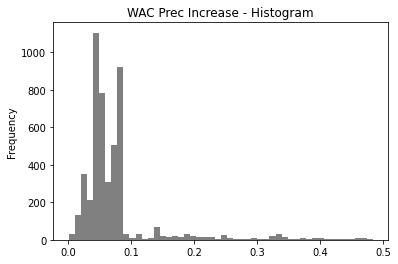

In [21]:
data[data['WAC Increase Amount'] <= 5000]['WAC Prec Increase'].plot.hist(bins = 50, color='grey')
plt.title('WAC Prec Increase - Histogram')
plt.show()

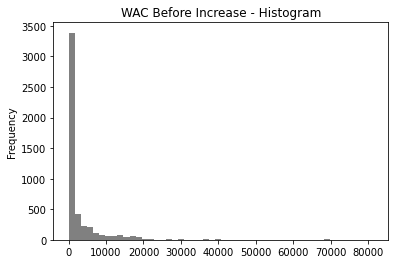

In [22]:
data[data['WAC Increase Amount'] <= 5000]['WAC Before Increase'].plot.hist(bins = 50, color='grey')
plt.title('WAC Before Increase - Histogram')
plt.show()

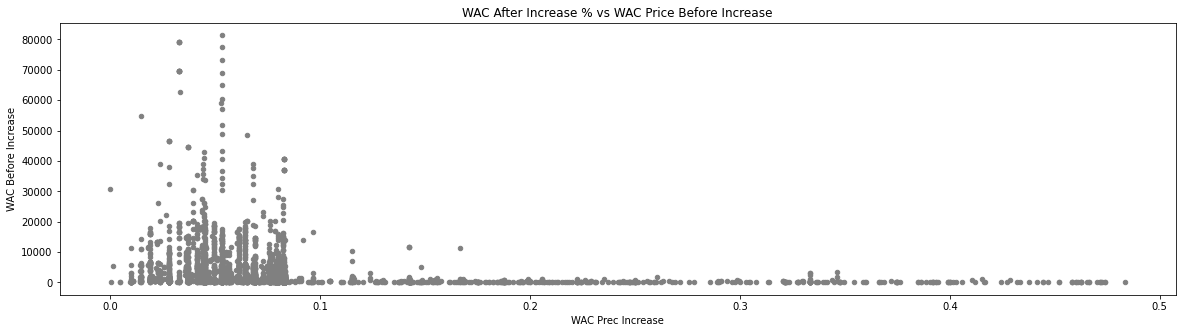

In [23]:
data[data['WAC Increase Amount'] <= 5000].plot(x = 'WAC Prec Increase', y = 'WAC Before Increase', kind = 'scatter', color= 'grey', figsize=(20, 5))
plt.title('WAC After Increase % vs WAC Price Before Increase')
plt.show()

###### Analyzing cost increase factor

In [24]:
textData = ''.join(list(data[~data['Cost Increase Factors'].isna()]['Cost Increase Factors'].to_string()))

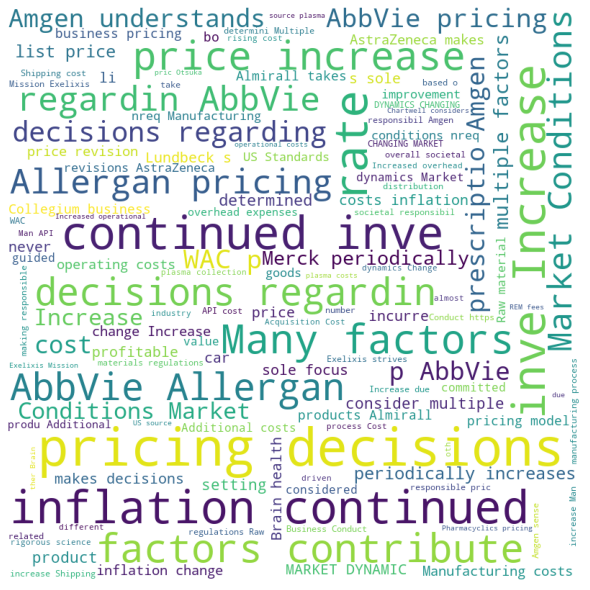

In [25]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(textData)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

- Mssing values with Nan and product names are forming majority of the text this need to be addressed during datapre

###### Checking frequent word distribution

In [26]:
data['Cost Increase Factors']

0                                                     NaN
1                                                     NaN
2       AMPYRA® has not been reformulated, but AMPYRA®...
3                                                     NaN
4                                                     NaN
                              ...                        
4876    Our pricing is guided by the value our product...
4877    Our pricing is guided by the value our product...
4878    Our pricing is guided by the value our product...
4879    Our pricing is guided by the value our product...
4880    Our pricing is guided by the value our product...
Name: Cost Increase Factors, Length: 4881, dtype: object

In [27]:
str(data['Drug Product Description'][2]).split(' ')[0].lower()

'ampyra'

In [28]:
##### Replacing drug names from description
wordList = []

for i, j in zip(data[~data['Cost Increase Factors'].isna()]['Cost Increase Factors'], data[~data['Cost Increase Factors'].isna()]['Drug Product Description']):
    wordList.extend(str(i).lower().replace(str(j).split(' ')[0].lower(), '').split(' '))

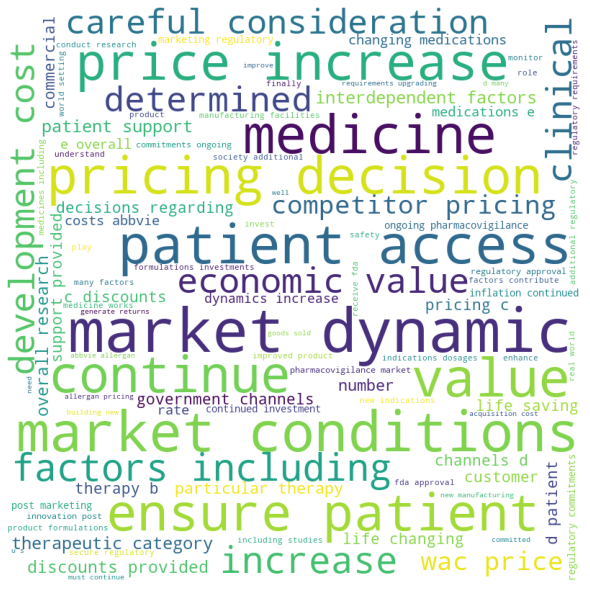

In [29]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS.union(set(['nan']))),
                min_font_size = 10).generate(' '.join(wordList))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

###### Top frequent words

<AxesSubplot:>

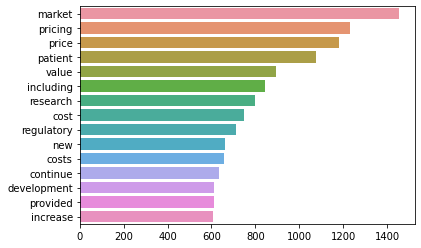

In [30]:
counter=collections.Counter(wordList)
most=counter.most_common()

x, y= [], []
for word,count in most[:30]:
    if (word not in set(STOPWORDS.union(set(['nan', ''])))):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

###### Observing frequent bigrams

In [31]:
counter=collections.Counter(nltk.bigrams(wordList))

### Bigram df
w1 = []
w2 = []
value = [] 
for i,j in zip(list(counter), list(counter.values())) :
    w1.append(i[0])
    w2.append(i[1])
    value.append(j)

bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)

In [32]:
bigramDf.head()

,word1,word2,freq
675,,,30346
219,in,the,711
23,cost,of,615
2330,of,a,601
2296,continue,to,590


In [33]:
#bigramDf.to_excel('../outputs/EDA Report/bigram.xlsx')

###### Observing frequent tri-grams

In [34]:
### Trigrams df
w1 = []
w2 = []
w3 = []
value = [] 
counter=collections.Counter(nltk.trigrams(wordList))
for i,j in zip(list(counter), list(counter.values())) :
    w1.append(i[0])
    w2.append(i[1])
    w3.append(i[2])
    value.append(j)

trigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'word2': w3, 'freq': value}).sort_values(['freq'], ascending = False)

In [35]:
#trigramDf.to_excel('../outputs/EDA Report/trigram.xlsx')

In [36]:
trigramDf.head()

,word1,word2,freq
720,,,29953
998,research,development,525
1205,the,of,400
603,ensure,access,396
2794,to,patient,390


###### Defining class for Text preprocessing

In [37]:
class textPreprocessing():
    '''
    Class takes text as input and return processed text post all data cleaning steps
    '''
    def __init__(self, text, dgName):
        self.procText = text
        self.drugName = dgName
       
    ## Module for text normalization
    def textNormalization(self):
        self.procText = self.procText.lower()
        
    ## Module for removing unwanted spaces
    def stripSpaces(self):
        self.procText = self.procText.strip()
    
    ## Module for stopwords removal
    def stopwordRemoval(self):
        self.procText = ' '.join([i for i in self.procText.split(' ') if i not in STOPWORDS])
        
    ## Module for removing special characters
    def specialCharRemoval(self):
        specialWords = ['.', ',', "'", '?', '-', '_', '+', '$', '®', '™', '(', ')']
        
        self.procText = ' '.join([re.sub("[^A-Z]", "", i,0,re.IGNORECASE) for i in self.procText.split(' ')])
        #for i in specialWords:
            #self.procText = re.sub(''+i, '', self.procText)
            
            
              
            
    ## Module for drug names from text
    def drugNameRemoval(self):
        #print(str(self.drugName).split(' ')[0].lower())
        #print(self.procText.replace(str(self.drugName).split(' ')[0].lower(), ''))
        self.procText = ' '.join(self.procText.replace(str(self.drugName).split(' ')[0].lower(), '').split(' '))
    
    ## Module for wordLemmatization
    def rootExtLemmatization(self):
        self.procText = ' '.join([WordNetLemmatizer().lemmatize(i) for i in self.procText.split(' ')])
    
    ## Module for call all preprocessing steps
    def all(self):
        self.textNormalization()

        self.stopwordRemoval()
        self.specialCharRemoval()
        self.drugNameRemoval()
        self.rootExtLemmatization()
        self.stripSpaces()
        return self.procText
                                   

###### Removing missing values

In [38]:
dataUpdated = data[~data['Cost Increase Factors'].isna()]
dataUpdated.reset_index(inplace = True)

###### Preprocessing

In [39]:
dataUpdated['Cost Increase Factors_Updated'] = [str(textPreprocessing(str(i), str(j)).all()) for i,j in zip(dataUpdated['Cost Increase Factors'], dataUpdated['Drug Product Description'])]

In [40]:
dataUpdated['Cost Increase Factors_Updated'][0:5][0]

'reformulated  manufacturer primary source revenue revenue recentlyapproved product inbrija increase'

In [41]:
dataUpdated['Cost Increase Factors'][0:5][0]

"AMPYRA® has not been reformulated, but AMPYRA® is the manufacturer's primary source of revenue while revenue from a more recently-approved product, INBRIJA™, increases."

In [42]:
### Exclude columns with greater than 30% missing values

In [43]:
##### Replacing drug names from description
wordListProcessed = " ".join(dataUpdated['Cost Increase Factors_Updated'])

In [44]:
counter=collections.Counter(nltk.bigrams(wordListProcessed.split(' ')))
### Bigram df
w1 = []
w2 = []
value = [] 
for i,j in zip(list(counter), list(counter.values())) :
    w1.append(i[0])
    w2.append(i[1])
    value.append(j)

bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)

In [45]:
bigramDf

,word1,word2,freq
58,,,26759
366,market,dynamic,598
593,research,development,537
283,market,condition,512
353,patient,access,503
...,...,...,...
3017,consistency,current,1
3018,market,market,1
3019,market,share,1
3020,share,determining,1


In [46]:
#bigramDf.to_excel('../outputs/EDA Report/bigram.xlsx')

In [47]:
### Trigrams df
w1 = []
w2 = []
w3 = []
value = [] 
counter=collections.Counter(nltk.trigrams(wordListProcessed.split(' ')))
for i,j in zip(list(counter), list(counter.values())) :
    w1.append(i[0])
    w2.append(i[1])
    w3.append(i[2])
    value.append(j)

trigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'word3': w3, 'freq': value}).sort_values(['freq'], ascending = False)

In [48]:
#trigramDf.to_excel('../outputs/EDA Report/trigram.xlsx')

In [49]:
trigramDf

,word1,word2,word3,freq
467,,,,26192
380,ensure,patient,access,403
1488,clinical,economic,value,357
863,research,development,cost,347
1768,determined,careful,consideration,335
...,...,...,...,...
3705,regulation,pbms,recognizing,1
3704,service,regulation,pbms,1
3703,preventive,service,regulation,1
3702,aca,preventive,service,1


In [50]:
#dataUpdated.to_csv('../outputs/cleanedText.csv')

###### Feature Engineering

In [51]:
np.isnan(dataUpdated['WAC Prec Increase']).sum()

0

In [52]:
textFeature = dataUpdated['Cost Increase Factors_Updated']
target = dataUpdated['WAC Prec Increase']

X_train, X_test, y_train, y_test = train_test_split(textFeature, target, test_size=0.2, random_state=2)

In [53]:
tkn = Tokenizer(num_words=2000)
tkn.fit_on_texts(textFeature)
X_trainTok = tkn.texts_to_sequences(X_train)
X_testTok = tkn.texts_to_sequences(X_test)

In [54]:
maxlen = 100

X_trainTok = pad_sequences(X_trainTok, padding='post', maxlen=maxlen)
X_testTok = pad_sequences(X_testTok, padding='post', maxlen=maxlen)

###### Model Development

- MLP Model

In [55]:
model = Sequential()
model.add(Dense(1024, input_shape=(X_trainTok.shape[1],), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

In [168]:
model.fit(X_trainTok, y_train, epochs=150, batch_size=10)

Epoch 1/150
147/147 [==============================] - 2s 5ms/step - loss: 0.3453 - accuracy: 0.0000e+00
Epoch 2/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 3/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 4/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 5/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 6/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 7/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 8/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 9/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 10/150
147/147 [==============================] -

147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 79/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 80/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 81/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 82/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 83/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 84/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 85/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 86/150
147/147 [==============================] - 1s 5ms/step - loss: 0.0420 - accuracy: 0.0000e+00
Epoch 87/150
147/147 [==============================] - 1s 

46/46 [==============================] - 1s 2ms/step


array([[0.05323203],
       [0.05323203],
       [0.05323203],
       ...,
       [0.05323203],
       [0.05323203],
       [0.05323203]], dtype=float32)

- Error Calculation

In [183]:
trainDf = pd.DataFrame({'Actual': y_train, 'Predicted': [i[0] for i in model.predict(X_trainTok)]})
trainDf['Error Prec'] = np.abs(trainDf['Actual'] - trainDf['Predicted'])/trainDf['Actual']
trainMape = np.mean(trainDf['Error Prec'])

testDf = pd.DataFrame({'Actual': y_test, 'Predicted': [i[0] for i in model.predict(X_testTok)]})
testDf['Error Prec'] = np.abs(testDf['Actual'] - testDf['Predicted'])/testDf['Actual']
testMape = np.mean(testDf['Error Prec'])

print("Train Error %s"%(trainMape))
print("Test Error %s"%(testMape))

12/12 [==============================] - 0s 3ms/step
Train Error 0.4808374368085169
Test Error 0.4365288196856697


- Model iteration on different epochs

In [58]:
def modelEpochs(ep):
    print(('Epoch - %s'%(ep)))
    model = Sequential()
    model.add(Dense(1024, input_shape=(X_trainTok.shape[1],), activation='relu'))
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
   # model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    model.fit(X_trainTok, y_train, epochs=ep, batch_size=10, verbose=0)
    
    trainDf = pd.DataFrame({'Actual': y_train, 'Predicted': [i[0] for i in model.predict(X_trainTok, verbose=0)]})
    trainDf['Error Prec'] = np.abs(trainDf['Actual'] - trainDf['Predicted'])/trainDf['Actual']
    trainMape = np.mean(trainDf['Error Prec'])

    testDf = pd.DataFrame({'Actual': y_test, 'Predicted': [i[0] for i in model.predict(X_testTok, verbose=0)]})
    testDf['Error Prec'] = np.abs(testDf['Actual'] - testDf['Predicted'])/testDf['Actual']
    testMape = np.mean(testDf['Error Prec'])

    return ep, trainMape, testMape

In [59]:
epList = []
taMapeList = []
teMapeList =  []
for i in range(1, 50, 2):
    ep, taMape, teMape = modelEpochs(i)
    epList.append(ep)
    taMapeList.append(taMape)
    teMapeList.append(teMape)

Epoch - 1
Epoch - 3
Epoch - 5
Epoch - 7
Epoch - 9
Epoch - 11
Epoch - 13
Epoch - 15
Epoch - 17
Epoch - 19
Epoch - 21
Epoch - 23
Epoch - 25
Epoch - 27
Epoch - 29
Epoch - 31
Epoch - 33
Epoch - 35
Epoch - 37
Epoch - 39
Epoch - 41
Epoch - 43
Epoch - 45
Epoch - 47
Epoch - 49


In [60]:
pd.DataFrame({'Epoch': epList, 'Train MAPE': taMapeList, 'Test MAPE': teMapeList})

,Epoch,Train MAPE,Test MAPE
0,1,0.484986,0.440361
1,3,0.514593,0.467854
2,5,0.458077,0.415482
3,7,0.482330,0.437919
4,9,0.466635,0.423265
5,11,0.493150,0.447764
6,13,0.472678,0.428914
7,15,0.496730,0.451022
8,17,0.482205,0.437802
9,19,0.473005,0.429219


In [61]:
pd.DataFrame({'Epoch': epList, 'Train MAPE': taMapeList, 'Test MAPE': teMapeList}).to_csv('../outputs/Data Preparation and Initial Model Report/Error_vs_Epochs.csv')